_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Coding Lab 7 : Transcriptomics



In [ ]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-25 11:22:17CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

matplotlib: 3.8.4
numpy     : 1.26.4
pandas    : 2.2.2

Watermark: 2.4.3



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [ ]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
print("Genes:", genes.size)
cells = data.columns[1:-1]
print("Cells:", cells.size)
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
print("Genes after filtering:", genes.size)
counts = counts[:, counts.sum(axis=0) > 0]
print("Counts of genes after filtering:", counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

Genes: 27998
Cells: 3663
Genes after filtering: 17965
Counts of genes after filtering: (3663, 17965)


## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [ ]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

# Compute the average expression for each gene
avg_exp = np.mean(counts, axis=0)

# Compute the fraction of zeros for each gene
frac_zeros = np.sum(counts == 0, axis=0) / counts.shape[0]

In [ ]:
# Compute the Poisson prediction
poisson = np.exp(
    -avg_exp
)  # probability of zeros in poisson distribution is exp of neg lambda

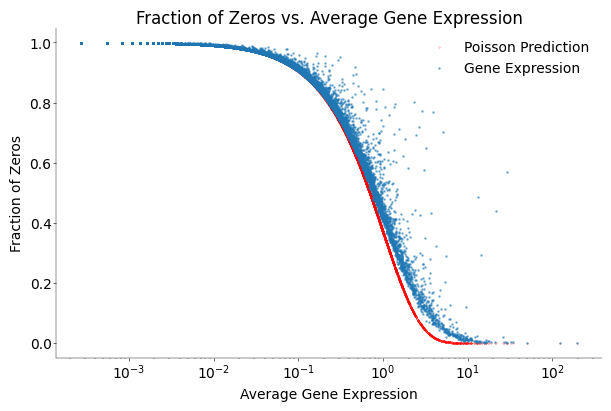

In [ ]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(avg_exp, poisson, s=0.1, c="red", label="Poisson Prediction")
ax.scatter(avg_exp, frac_zeros, s=3, alpha=0.5, label="Gene Expression")
ax.set_title("Fraction of Zeros vs. Average Gene Expression")
ax.set_xlabel("Average Gene Expression")
ax.set_ylabel("Fraction of Zeros")
ax.set_xscale("log")
ax.legend()
plt.show()
# add plot

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [ ]:
# Compute the variance of the expression counts of each gene
var_exp = np.var(counts, axis=0)
avg_exp = np.mean(counts, axis=0)

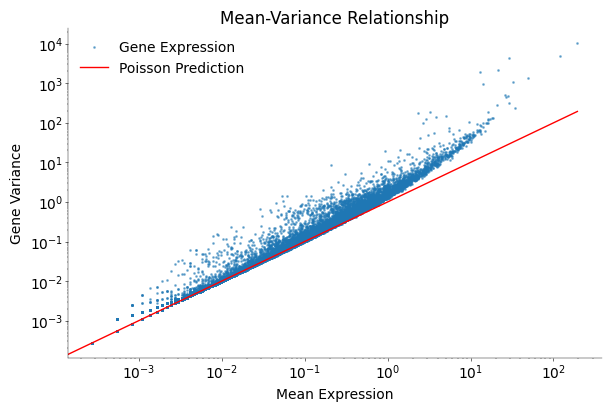

In [ ]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(avg_exp, var_exp, s=4, alpha=0.5, label="Gene Expression")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Mean Expression")
ax.set_ylabel("Gene Variance")
ax.set_title("Mean-Variance Relationship")

x = np.linspace(0, max(avg_exp), 100)
y = x  # For Poisson distribution, variance = mean
ax.plot(x, y, color="red", label="Poisson Prediction")
ax.legend()
plt.show()
# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [ ]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.

fano = var_exp / avg_exp

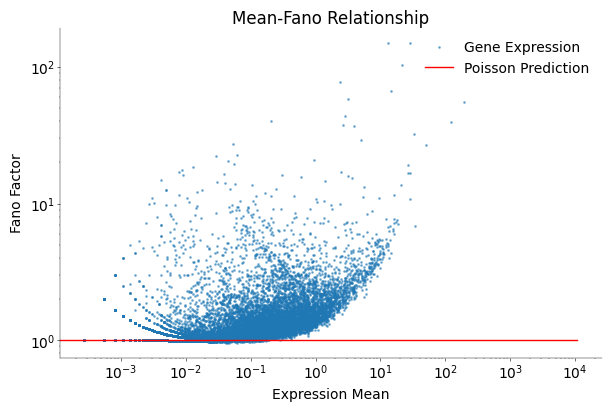

In [ ]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(avg_exp, fano, s=4, alpha=0.5, label="Gene Expression")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Expression Mean")
ax.set_ylabel("Fano Factor")
ax.set_title("Mean-Fano Relationship")

x = np.linspace(0, max(var_exp), 100)
y = np.ones(
    len(x)
)  # Poisson predicition: Fano Factor should always be one as mean = var in poisson
ax.plot(x, y, color="red", label="Poisson Prediction")
ax.legend()
plt.show()


# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

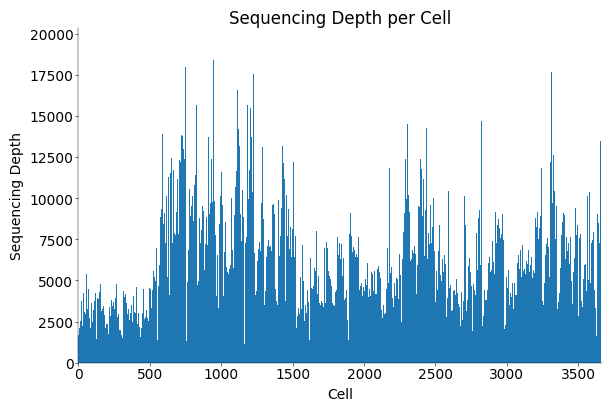

In [ ]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell
sequencing_depth = np.sum(counts, axis=1)  # across axis 1 or 0?

fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------
binwidth = 0.1
ax.bar(
    np.arange(0, len(sequencing_depth), 1), sequencing_depth, width=1
)  # we didn't use histogram function as cells can not be binned
#
ax.set_title("Sequencing Depth per Cell")
ax.set_xlabel("Cell")
ax.set_ylabel("Sequencing Depth")
ax.set_xlim(-1, len(sequencing_depth) + 1)
plt.show()

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [ ]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above

norm = (counts / sequencing_depth[:, np.newaxis]) * np.median(sequencing_depth)

# compute fano factor again
avg_exp_norm = np.mean(norm, axis=0)
fano_norm = np.var(norm, axis=0) / avg_exp_norm

# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------

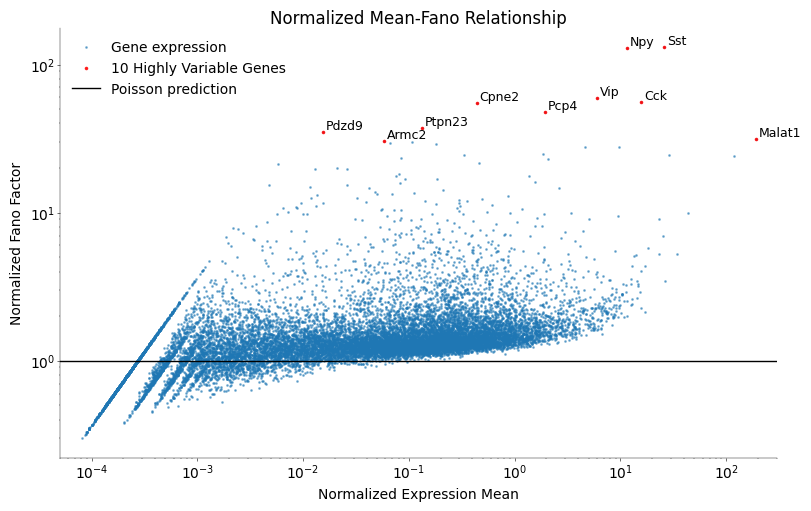

In [ ]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

top_ten_indices = np.argsort(fano_norm)[-10:]
top_ten_fano = fano_norm[top_ten_indices]
top_ten_avg_exp = avg_exp_norm[top_ten_indices]
top_ten_genes = genes[top_ten_indices]


fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(avg_exp_norm, fano_norm, s=4, alpha=0.5, label="Gene expression")

# plot top ten (just overwrite the other dots)
ax.scatter(
    top_ten_avg_exp,
    top_ten_fano,
    color="red",
    s=10,
    alpha=0.8,
    label="10 Highly Variable Genes", 
)
for i, gene in enumerate(top_ten_genes):
    ax.annotate(
        gene,
        (
            top_ten_avg_exp[i],
            top_ten_fano[i],
        ),
        fontsize=9,
        color="black",
        xytext=(2, 2),
        textcoords="offset points",
    )

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((0.00005, 300))
ax.set_xlabel("Normalized Expression Mean")
ax.set_ylabel("Normalized Fano Factor")
ax.set_title("Normalized Mean-Fano Relationship")
x = np.linspace(0, max(var_exp), 100)
y = np.ones(
    len(x)
)  # Poisson predicition: Fano Factor should always be one as mean = var in poisson
ax.plot(x, y, color="black", label="Poisson prediction")
ax.legend(loc="upper left")
plt.show()

In [ ]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array#

for gene, fano in zip(top_ten_genes[::-1], top_ten_fano[::-1]):
    print(f"Gene: {gene}  Fano: {fano:.2f}")

Gene: Sst  Fano: 131.14
Gene: Npy  Fano: 128.40
Gene: Vip  Fano: 59.11
Gene: Cck  Fano: 55.65
Gene: Cpne2  Fano: 55.22
Gene: Pcp4  Fano: 47.65
Gene: Ptpn23  Fano: 37.25
Gene: Pdzd9  Fano: 35.06
Gene: Malat1  Fano: 31.42
Gene: Armc2  Fano: 30.59


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [ ]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------

# Transform the counts into normalized counts (as above)
print("Normalized counts shape:", norm.shape)
print("Fano factor shape:", fano_norm.shape)
# Select all genes with the normalized Fano factor above 3 and remove the rest
genes_fano3 = genes[fano_norm > 3]
print("Genes with Fano factor > 3:", genes_fano3.size)
counts_fano3 = norm[:, fano_norm > 3]
print("Counts of genes with Fano factor > 3 for all cells:", counts_fano3.shape)

Normalized counts shape: (3663, 17965)
Fano factor shape: (17965,)
Genes with Fano factor > 3: 707
Counts of genes with Fano factor > 3 for all cells: (3663, 707)


In [ ]:
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA

# Perform PCA on the raw normalized counts
pca_raw = PCA(n_components=50)
X_pca_raw = pca_raw.fit_transform(counts_fano3)

# Perform PCA on the log2 transformed counts
pca_log2 = PCA(n_components=50)
X_pca_log2 = pca_log2.fit_transform(np.log2(counts_fano3 + 1))

# Perform PCA on the sqrt transformed counts
pca_sqrt = PCA(n_components=50)
X_pca_sqrt = pca_sqrt.fit_transform(np.sqrt(counts_fano3))

In [ ]:
print(counts_fano3.shape, pca_raw.components_.shape)

(3663, 707) (50, 707)


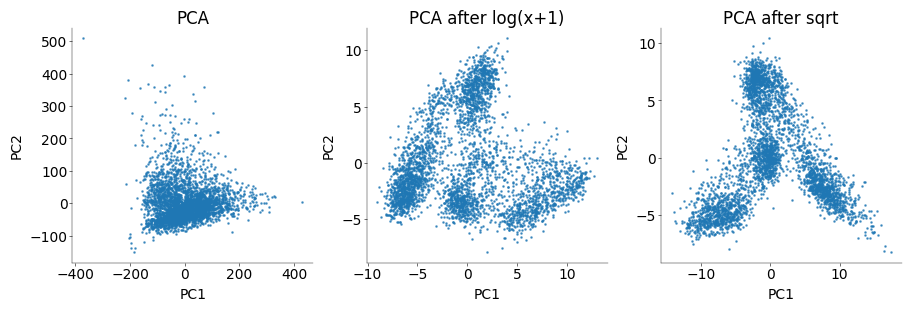

In [ ]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
for ax, pca, title in zip(
    axs,
    [X_pca_raw, X_pca_log2, X_pca_sqrt],
    ["PCA", "PCA after log(x+1)", "PCA after sqrt"],
):
    ax.scatter(pca[:, 0], pca[:, 1], s=3, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
plt.show()

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [ ]:
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------
from openTSNE import TSNE

# Apply t-SNE to the 50 PCs
tsne = TSNE()
tsne_emb = tsne.fit(X_pca_raw)
tsne_log = TSNE()
tsne_log_emb = tsne_log.fit(X_pca_log2)
tsne_sqrt = TSNE()
tsne_sqrt_emb = tsne_sqrt.fit(X_pca_sqrt)

tsne_embeddings = [tsne_emb, tsne_log_emb, tsne_sqrt_emb]

# Use default settings of openTSNE
# You can also use sklearn if you want

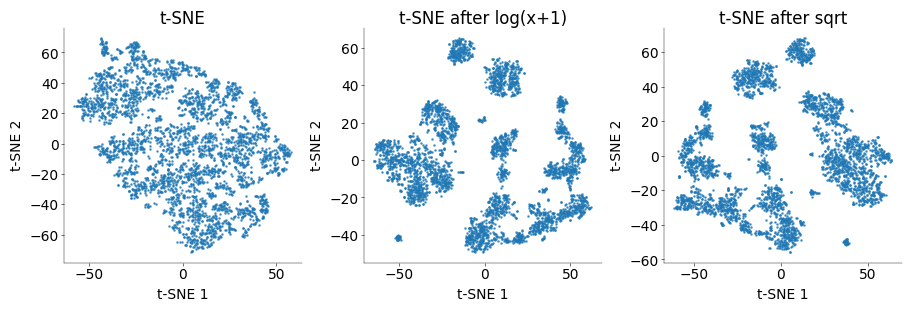

In [ ]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
for ax, tsne, title in zip(
    axs, tsne_embeddings, ["t-SNE", "t-SNE after log(x+1)", "t-SNE after sqrt"]
):
    ax.scatter(tsne[:, 0], tsne[:, 1], s=3, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
plt.show()

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [ ]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [ ]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------
Graphs = []

for tsne_data in [tsne_emb, tsne_log_emb, tsne_sqrt_emb]:

    # Construct kNN graph with k=15
    nn = NearestNeighbors(n_neighbors=15, metric="euclidean")
    nn.fit(tsne_data)
    A = nn.kneighbors_graph(tsne_data, mode="connectivity")

    # Transform it into an igraph object
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    edges = list(zip(sources, targets))
    G = ig.Graph(
        n=tsne_data.shape[0], edges=edges, edge_attrs={"weight": weights}
    )  # Set weights

    Graphs.append(G)

In [ ]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type

Partitions = [la.find_partition(g, la.RBConfigurationVertexPartition) for g in Graphs]

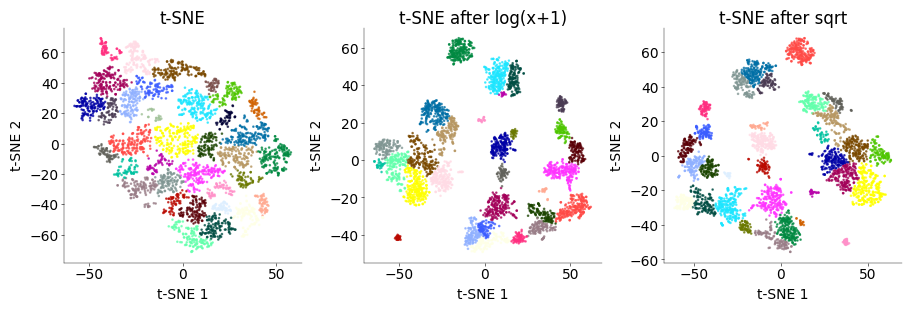

In [ ]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
for ax, tsne, title, g, p in zip(
    axs,
    tsne_embeddings,
    ["t-SNE", "t-SNE after log(x+1)", "t-SNE after sqrt"],
    Graphs,
    Partitions,
):
    cluster_labels = np.array(p.membership)
    cluster_colors = clusterCols[cluster_labels]

    ax.scatter(tsne[:, 0], tsne[:, 1], c=cluster_colors, s=3, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [ ]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

/tmp/ipykernel_10273/2606864680.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing to prevent overlapping


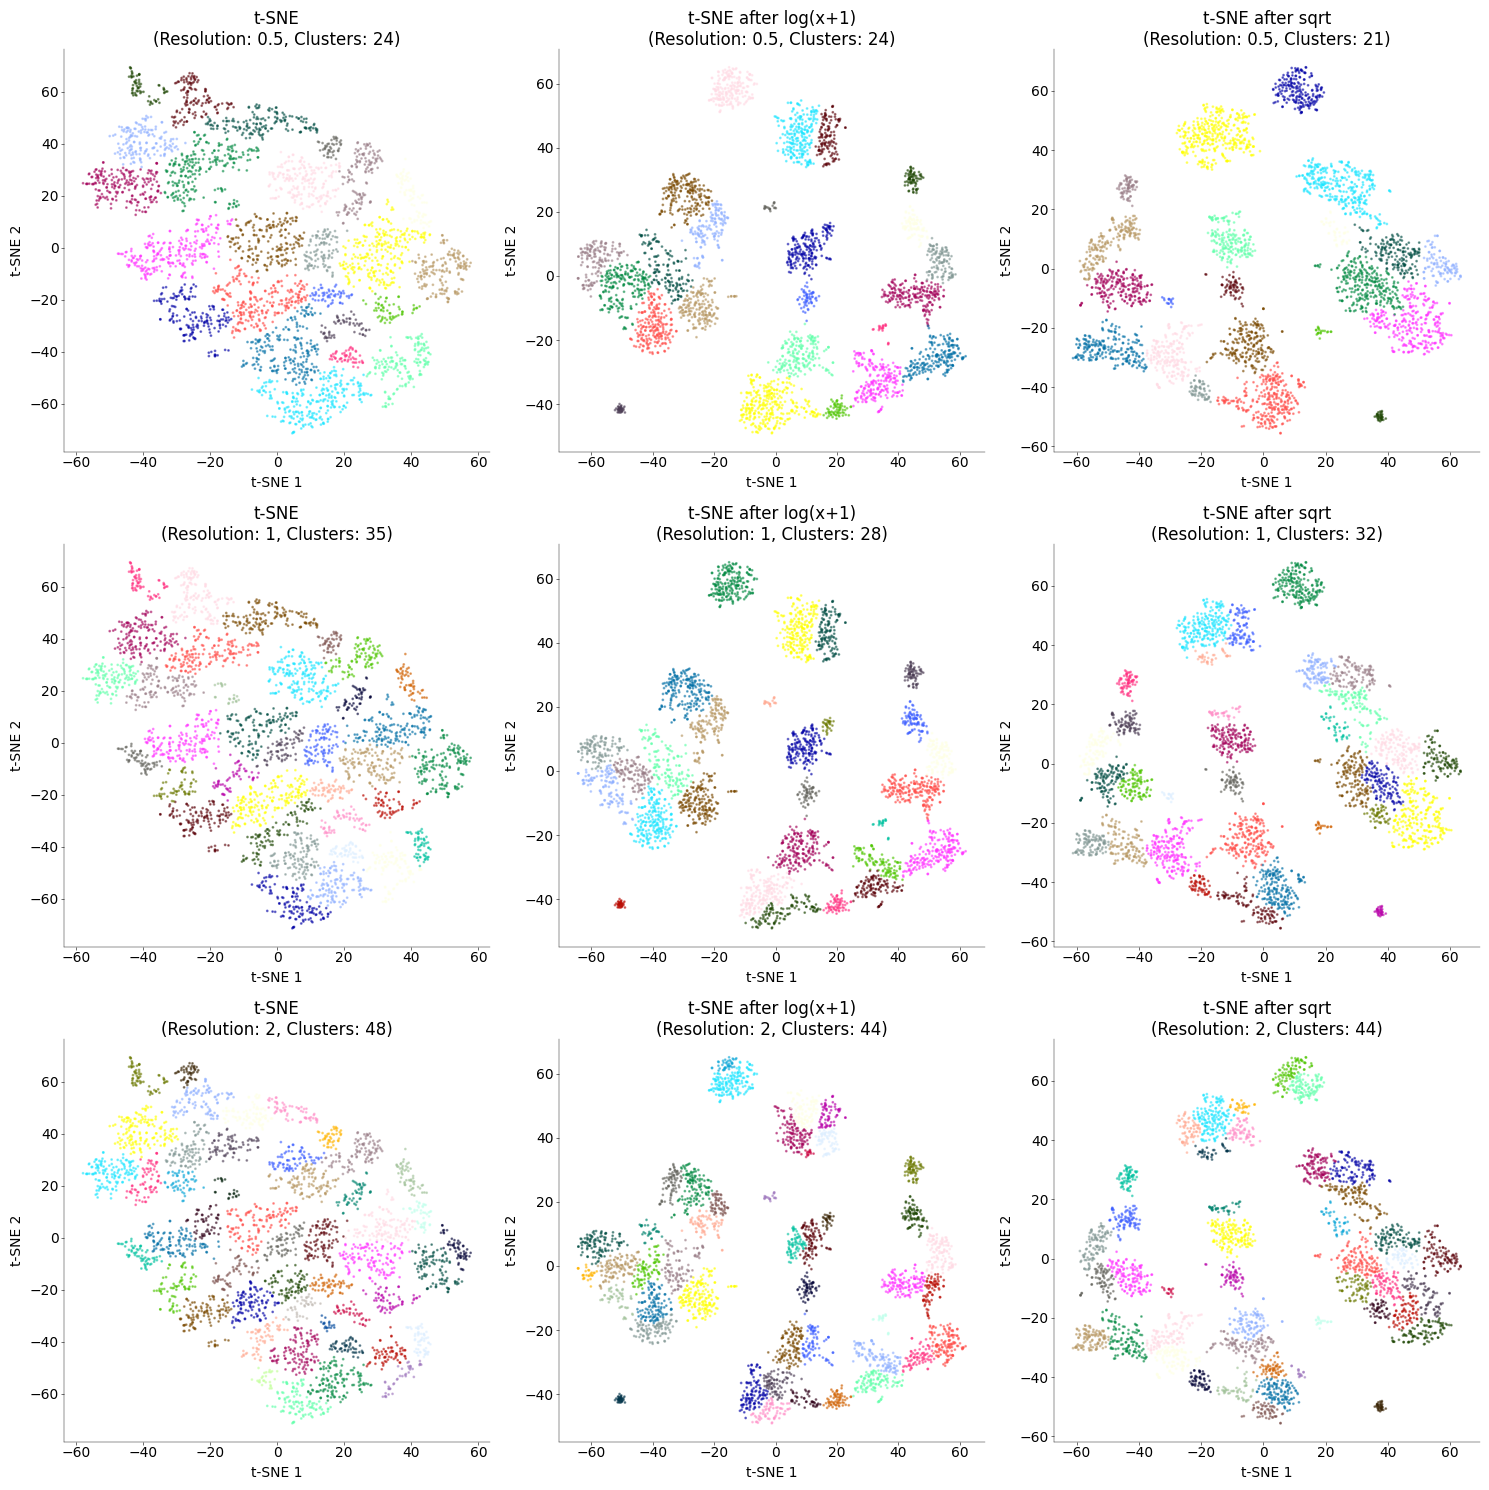

In [ ]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

# Define resolution parameters
resolutions = [0.5, 1, 2]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid
# Iterate over resolutions
for row, resolution in enumerate(resolutions):
    Partitions = [
        la.find_partition(
            g, la.RBConfigurationVertexPartition, resolution_parameter=resolution
        )
        for g in Graphs
    ]

    # Iterate over t-SNE embeddings, plots, graphs, and partitions
    for col in range(3):  # Iterate over columns
        tsne_data = [tsne_emb, tsne_log_emb, tsne_sqrt_emb][col]
        title = ["t-SNE", "t-SNE after log(x+1)", "t-SNE after sqrt"][col]
        g = Graphs[col]
        p = Partitions[col]

        # Get cluster labels and colors
        cluster_labels = np.array(p.membership)
        n_clusters = len(set(cluster_labels))
        cluster_colors = clusterCols[cluster_labels]

        # Create scatter plot
        axs[row, col].scatter(
            tsne_data[:, 0], tsne_data[:, 1], c=cluster_colors, alpha=0.5, s=4
        )

        # Set title (including number of clusters)
        axs[row, col].set_title(
            f"{title}\n(Resolution: {resolution}, Clusters: {n_clusters})"
        )
        axs[row, col].set_xlabel("t-SNE 1")
        axs[row, col].set_ylabel("t-SNE 2")

plt.tight_layout()  # Adjust spacing to prevent overlapping
plt.show()